In [1]:
# environment
import matplotlib.font_manager as fm
import numpy as np
import random as rand
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
import os 
import math as mt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
%matplotlib notebook

cwd = os.getcwd()
pwd = os.path.abspath(os.path.join(cwd, os.pardir))
fontloc = pwd + '/Fonts/SFMono-Regular.otf'
font = fm.FontProperties(fname = fontloc,size = 8); prop = font
proplr = fm.FontProperties(fname = fontloc,size = 12)

fontlocit = pwd + '/Fonts/SFMono-RegularItalic.otf'
fontit = fm.FontProperties(fname = fontlocit,size = 8)

#ticks font
def ticks(ax, size):
    font = fm.FontProperties(fname = fontloc,size = size)
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)
        
def xticks(ax, size):
    font = fm.FontProperties(fname = fontloc,size = size)
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
        
def yticks(ax, size):
    font = fm.FontProperties(fname = fontloc,size = size)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)

@ticker.FuncFormatter
def major_formatter(x, pos):
    label = str("{0:.1f}".format(x)) if x < 0 else str("{0:.2f}".format(x))
    return label

In [2]:
import sdeint

#sample initial conditions
Toi = 1.0
Tai = 1.0

# model parameters, variables and functions
tune = 0.10           #model tuning parameter
Coo = -1.08 * tune
Coa = 1.0 * tune
Cao = 0.1 * tune
Caa = -1.12 * tune
M = [10.0, 10.0]       #range

# define forcing function (weiner process with <cross-section>)
scale = 0.05          #relative amplitude of stochastic forcing
crosssec = scale * Tai
#crosssec = 0.0

# time series
ini = 500            #initialisation
t_start = 0.0
t_end = 500.0 + ini
time_samples = 500 + ini
resolution = (t_end - t_start)/time_samples

# DA samples
time_stable = ini/(t_end - t_start)     #ignore first <N> samples as DA stabilises; fraction of total DA steps

def close(func, *args):
    def newfunc(x, t):
        return func(x, t, *args)
    return newfunc

def autocorr(x,t):
    result = np.correlate(x, x, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def crosscorr(x,y,t):
    result = np.correlate(x, y, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def f(x, t, m):
    To = x[0]
    Ta = x[1]
    f0 = (1/m)*(Coo*To + Coa*Ta)
    f1 = Cao*To + Caa*Ta
    return [f0,f1]

t = np.linspace(start=t_start, stop=t_end, num=time_samples + 1)

# set white noise forcing amplitude
W = np.diag([0.0, crosssec])

# redefine unforced part
def unforc(x, t, m):
    C = np.array([[(1/m)*Coo, (1/m)*Coa],
              [Cao, Caa]])
    return C.dot(x)

def forc(x, t):
    return W

In [3]:
#solve the system of ODEs with a sample set of initial conditions
samples = 10
rand.seed(546)     #to fix initial conditions
Toi_lim = Toi      #maximum amplitude of variability in ocean
Tai_lim = Tai      #maximum amplitude of variability in atmosphere

for m in np.arange(M[0], M[-1] + 1):
    peak_corr = []
    To_l = []; Ta_l = []
    VecCorr = []; LagCorr = []
    for i in range(samples):
        #x0 = [rand.uniform(-Toi_lim, Toi_lim), rand.uniform(-Tai_lim, Tai_lim)]
        x0 = [Toi, Tai]
        args = (m,)
        soln = sdeint.itoint(close(unforc, *args),forc,x0,t)
        To_t = soln[:,0]; To_l.append(To_t)    #list with all oceanic temperatures per sample
        Ta_t = soln[:,1]; Ta_l.append(Ta_t)    #list with all atmospheric temperatures per sample
        [lag_time, crosscor] = crosscorr(Ta_t,To_t,t)
        VecCorr.append(crosscor); LagCorr.append(lag_time)
        max_index = np.argmax(crosscor)
        peak_corr.append(abs(lag_time[max_index]))
    if 0 == 1:
        np.random.seed(int(m))
        randsamp = np.random.randint(0,samples)
        with open(pwd + '/ToyModel_1/Data/Oce_P_obs_' + str(int(m)) + '.log', 'w') as f:
            for item in To_l[randsamp]:
                f.write("%s\n" % item)
        with open(pwd + '/ToyModel_1/Data/Atm_P_obs_' + str(int(m)) + '.log', 'w') as f:
            for item in Ta_l[randsamp]:
                f.write("%s\n" % item)
    else:
        np.random.seed(int(m))
        randsamp = np.random.randint(0,samples)

In [4]:
import warnings
warnings.filterwarnings("error")

#set DA variables for LACC simulation
atm_dev = 0.050       #assumed standard deviation in atmospheric observations
oce_dev = 0.020       #assumed standard deviation in oceanic observations
atm_syn = 0.050       #to generate atmospheric observation vector
oce_syn = 0.020       #to generate oceanic observation vector
Win = [1,1]          #window limits
Set = [1,1]           #[0,0] = None; [0,1] = A -> O; [1,0] = O -> A; [1,1] = Both 
NaN = np.float('nan')

def myround(x, base):
    return base * round(x/base)

def WCDA(ocean_v, atmos_v, t, win, item, atm_dev, oce_dev, m):
    oce_for_c = []; atm_for_c = []; oce_for = []; atm_for = []; oce_ana = []; atm_ana = []
    iter0 = 0; iter1 = 0; flag = 0; KalGainC = []; KalGainA = [] ; KalGainO = [] 
    oce_gain = 0; atm_gain = 0; oce_gain_c = 0; atm_gain_c = 0
    oce_se = []; atm_se = []
    for num, time in enumerate(t):
        if num < ini:  #initialisation loop for <ini - 1> steps
            if num > 0:#offset
                sol   = sdeint.itoint(close(unforc, *args),forc,[oce_ana[-1],atm_ana[-1]],[0,1])
                oce_for.append(sol[1,0]); atm_for.append(sol[1,1])
                oce_ana.append(sol[1,0]); atm_ana.append(sol[1,1])
            else:
                oce_for.append(Toi); atm_for.append(Tai)
                oce_ana.append(Toi); atm_ana.append(Tai)
            oce_se.append(np.abs(oce_ana[-1] - oce_obs[num])**2)
            atm_se.append(np.abs(atm_ana[-1] - atm_obs[num])**2)
            flag = 'None'
        else:                    #start DA after <ini> time steps
            if time % win == 0.0 and num > win - 1: 
                sol   = sdeint.itoint(close(unforc, *args),forc,[oce_ana[-1],atm_ana[-1]],[0,1])
                oce_for.append(sol[1,0]); atm_for.append(sol[1,1])   
                try:
                    covar_matrix   = np.cov(np.array([oce_for,atm_for]))
                    var_atm   =   covar_matrix[1][1]
                    var_oce   =   covar_matrix[0][0]
                    flag = 'lowered WCDA'
                except RuntimeWarning:
                    var_atm   = 0.0; var_oce   = 0.0
                    flag = 'raised WCDA' 
                Ka = ((var_atm))/((var_atm) + (atm_dev)**2)
                Ko = ((var_oce))/((var_oce) + (oce_dev)**2)
                oce_gain   = Ko * (oce_obs[num] - oce_for[-1])
                atm_gain   = Ka * (atm_obs[num] - atm_for[-1])
                KalGainO.append(Ko); KalGainA.append(Ka)
                ocean = oce_for[-1] + oce_gain
                atmos = atm_for[-1] + atm_gain
                oce_ana.append(ocean); atm_ana.append(atmos)
                oce_se.append(np.abs(oce_ana[-1] - oce_obs[num])**2)
                atm_se.append(np.abs(atm_ana[-1] - atm_obs[num])**2)
                iter1 = iter1 + 1; iter0 = iter0 + 1
            else:
                sol   = sdeint.itoint(close(unforc, *args),forc,[oce_ana[-1],atm_ana[-1]],[0,1])
                oce_for.append(sol[1,0]); atm_for.append(sol[1,1])
                try:
                    covar_matrix = np.cov(np.array([oce_for,atm_for]))
                    var_oce = covar_matrix[0][0]
                    var_atm = covar_matrix[1][1]
                    flag = 'lowered WDA'
                except RuntimeWarning:
                    var_oce = 0.0; var_atm = 0.0
                    flag = 'raised WDA'
                Ka = ((var_atm))/((var_atm) + (atm_dev)**2)
                Ko = ((var_oce))/((var_oce) + (oce_dev)**2)
                oce_gain = Ko * (oce_obs[num] - oce_for[-1])
                atm_gain = Ka * (atm_obs[num] - atm_for[-1])
                KalGainO.append(Ko); KalGainA.append(Ka)
                oce_gain_c = 0; atm_gain_c = 0
                ocean = oce_for[-1] + oce_gain_c + oce_gain
                atmos = atm_for[-1] + atm_gain_c + atm_gain
                oce_ana.append(ocean); atm_ana.append(atmos)
                oce_se.append(np.abs(oce_ana[-1] - oce_obs[num])**2)
                atm_se.append(np.abs(atm_ana[-1] - atm_obs[num])**2)
                iter1 = iter1 + 1     
    return oce_se, atm_se

def SCDA(ocean_v, atmos_v, t, win, item, atm_dev, oce_dev, m):
    oce_for_c = []; atm_for_c = []; oce_for = []; atm_for = []; oce_ana = []; atm_ana = []
    iter0 = 0; iter1 = 0; flag = 0; KalGainC = []; KalGainA = [] ; KalGainO = []; KalGainD = []
    oce_gain = 0; atm_gain = 0; oce_gain_c = 0; atm_gain_c = 0
    oce_se = []; atm_se = []
    for num, time in enumerate(t):
        if num < ini:  #initialisation loop for <ini - 1> steps, assumes win < ini
            if num > 0:#offset
                sol   = sdeint.itoint(close(unforc, *args),forc,[oce_ana[-1],atm_ana[-1]],[0,1])
                oce_for.append(sol[1,0]); atm_for.append(sol[1,1])
                oce_ana.append(sol[1,0]); atm_ana.append(sol[1,1])
            else:
                oce_for.append(Toi); atm_for.append(Tai)
                oce_ana.append(Toi); atm_ana.append(Tai)
            oce_se.append(np.abs(oce_ana[-1] - oce_obs[num])**2)
            atm_se.append(np.abs(atm_ana[-1] - atm_obs[num])**2)
            flag = 'None'
            if time % win == 0.0:
                if num > 0:
                    if Set[0] == 0 and Set[-1] == 0:
                        oce_for_c.append(oce_for[num])
                        atm_for_c.append(atm_for[num])
                    elif Set[0] == 0 and Set[-1] == 1:
                        atm_for_c.append(np.mean(atm_for[num - win + 1:num + 1]))   #mean over previous <win> times for atmos
                        oce_for_c.append(oce_for[num])
                    elif Set[0] == 1 and Set[-1] == 0:
                        oce_for_c.append(np.mean(oce_for[num - win + 1:num + 1]))   #mean over previous <win> times for ocean
                        atm_for_c.append(atm_for[num])
                    elif Set[0] == 1 and Set[-1] == 1:
                        atm_for_c.append(np.mean(atm_for[num - win + 1:num + 1]))   #mean over previous <win> times for atmos
                        oce_for_c.append(np.mean(oce_for[num - win + 1:num + 1]))   #mean over previous <win> times for ocean
                    else:
                        error('Illegal Input')
                else:
                    oce_for_c.append(oce_for[0])
                    atm_for_c.append(atm_for[0])
                iter0 = iter0 + 1
        else:                    #start DA after <ini> time steps
            if time % win == 0.0 and num > win - 1:    
                sol   = sdeint.itoint(close(unforc, *args),forc,[oce_ana[-1],atm_ana[-1]],[0,1])
                oce_for.append(sol[1,0]); atm_for.append(sol[1,1])
                if Set[0] == 0 and Set[-1] == 0:
                    oce_for_c.append(oce_for[num])
                    atm_for_c.append(atm_for[num])
                    atm_de2 = atm_dev
                    oce_de2 = oce_dev
                elif Set[0] == 0 and Set[-1] == 1:
                    atm_for_c.append(np.mean(atm_for[num - win + 1:num + 1]))   #mean over previous <win> times for atmos
                    oce_for_c.append(oce_for[num])
                    atm_de2 = atm_dev/np.sqrt(win)
                    oce_de2 = oce_dev
                elif Set[0] == 1 and Set[-1] == 0:
                    oce_for_c.append(np.mean(oce_for[num - win + 1:num + 1]))   #mean over previous <win> times for ocean
                    atm_for_c.append(atm_for[num])
                    atm_de2 = atm_dev
                    oce_de2 = oce_dev/np.sqrt(win)
                elif Set[0] == 1 and Set[-1] == 1:
                    atm_for_c.append(np.mean(atm_for[num - win + 1:num + 1]))   #mean over previous <win> times for atmos
                    oce_for_c.append(np.mean(oce_for[num - win + 1:num + 1]))   #mean over previous <win> times for ocean
                    atm_de2 = atm_dev/np.sqrt(win)
                    oce_de2 = oce_dev/np.sqrt(win)
                else:
                    error('Illegal Input')
                atm_mean = atm_for_c[-1]; oce_mean = oce_for_c[-1]
                try:
                    covar_matrix_c = np.cov(np.array([oce_for_c,atm_for_c]))
                    covar_c   = covar_matrix_c[0][1]
                    var_atm_c = covar_matrix_c[1][1]
                    var_oce_c = covar_matrix_c[0][0]
                    covar_matrix   = np.cov(np.array([oce_for,atm_for]))
                    covar     =   covar_matrix[0][1]
                    var_atm   =   covar_matrix[1][1]
                    var_oce   =   covar_matrix[0][0]
                    flag = 'lowered CDA'
                except RuntimeWarning:
                    covar_c   = 0.0; var_atm_c = 0.0; var_oce_c = 0.0
                    covar     = 0.0; var_atm   = 0.0; var_oce   = 0.0
                    flag = 'raised CDA' 
                D  = (((var_oce_c) + (oce_de2)**2)*((var_atm_c) + (atm_de2)**2) - (covar_c**2))
                Kc = (covar_c*((oce_de2)**2))/D
                Kd = (covar_c*((atm_de2)**2))/D
                Ka = ((var_atm_c)*(var_oce_c + (oce_de2)**2) - (covar_c**2))/D
                Ko = ((var_oce_c)*(var_atm_c + (atm_de2)**2) - (covar_c**2))/D
                if Set[0] == 0 and Set[-1] == 0:
                    atm_gain_c = 0.0
                    oce_gain_c = 0.0
                elif Set[0] == 0 and Set[-1] == 1:
                    oce_gain_c = Kc * (atm_obs_mean[iter0] - atm_mean)
                    atm_gain_c = 0.0
                elif Set[0] == 1 and Set[-1] == 0:
                    oce_gain_c = 0.0
                    atm_gain_c = Kd * (oce_obs_mean[iter0] - oce_mean)
                elif Set[0] == 1 and Set[-1] == 1:
                    oce_gain_c = Kc * (atm_obs_mean[iter0] - atm_mean)
                    atm_gain_c = Kd * (oce_obs_mean[iter0] - oce_mean)
                else:
                    error('Illegal Input')
                oce_gain   = Ko * (oce_obs[num] - oce_for[-1])
                atm_gain   = Ka * (atm_obs[num] - atm_for[-1])
                KalGainD.append(Kd); KalGainC.append(Kc); KalGainO.append(Ko); KalGainA.append(Ka)
                ocean = oce_for[-1] + oce_gain_c + oce_gain
                atmos = atm_for[-1] + atm_gain_c + atm_gain
                oce_ana.append(ocean); atm_ana.append(atmos)
                oce_se.append(np.abs(oce_ana[-1] - oce_obs[num])**2)
                atm_se.append(np.abs(atm_ana[-1] - atm_obs[num])**2)
                iter1 = iter1 + 1; iter0 = iter0 + 1
            else:
                sol   = sdeint.itoint(close(unforc, *args),forc,[oce_ana[-1],atm_ana[-1]],[0,1])
                oce_for.append(sol[1,0]); atm_for.append(sol[1,1])
                try:
                    covar_matrix = np.cov(np.array([oce_for,atm_for]))
                    var_oce = covar_matrix[0][0]
                    var_atm = covar_matrix[1][1]
                    flag = 'lowered WDA'
                except RuntimeWarning:
                    var_oce = 0.0; var_atm = 0.0
                    flag = 'raised WDA'
                Ka = ((var_atm))/((var_atm) + (atm_dev)**2)
                Ko = ((var_oce))/((var_oce) + (oce_dev)**2)
                oce_gain = Ko * (oce_obs[num] - oce_for[-1])
                atm_gain = Ka * (atm_obs[num] - atm_for[-1])
                KalGainO.append(Ko); KalGainA.append(Ka)
                oce_gain_c = 0; atm_gain_c = 0
                ocean = oce_for[-1] + oce_gain_c + oce_gain
                atmos = atm_for[-1] + atm_gain_c + atm_gain
                oce_ana.append(ocean); atm_ana.append(atmos)
                oce_se.append(np.abs(oce_ana[-1] - oce_obs[num])**2)
                atm_se.append(np.abs(atm_ana[-1] - atm_obs[num])**2)
                iter1 = iter1 + 1 
    return oce_se, atm_se

time_plot = [int(t[0]), int(t[-1])]
half      = int(round(time_plot[-1] - time_plot[0]/2))
OutO      = []; OutA      = []

for m in np.arange(M[0], M[-1] + 1):
    #read observation file
    To_s = []; Ta_s = []
    with open(pwd + '/ToyModel_1/Data/Oce_P_obs_' + str(int(m)) + '.log') as f:
        for line in f.readlines():
              To_s.append(float(line))
    with open(pwd + '/ToyModel_1/Data/Atm_P_obs_' + str(int(m)) + '.log') as f:
        for line in f.readlines():
              Ta_s.append(float(line))
            
    np.random.seed(int(m))
    atm_obs = [val + noi for val, noi in zip(Ta_s, np.random.normal(0.0, atm_syn, len(t)))]     #atmos obs vector
    oce_obs = [val + noi for val, noi in zip(To_s, np.random.normal(0.0, oce_syn, len(t)))]     #atmos obs vector
    vecO = []; vecA = []
    
    for win in range(Win[0], Win[-1] + 1):
        oce_obs_mean = []; atm_obs_mean = []
        for num, time in enumerate(t):
            if time % win == 0.0:      #mean vector atmos
                if num > win - 1:   
                    if Set[0] == 0 and Set[-1] == 0:
                        oce_obs_mean.append(np.mean(oce_obs[num]))
                        atm_obs_mean.append(np.mean(atm_obs[num]))
                    elif Set[0] == 0 and Set[-1] == 1:
                        atm_obs_mean.append(np.mean(atm_obs[num - win + 1:num + 1]))   #mean over previous <win> times for atmos
                        oce_obs_mean.append(np.mean(oce_obs[num]))
                    elif Set[0] == 1 and Set[-1] == 0:
                        oce_obs_mean.append(np.mean(oce_obs[num - win + 1:num + 1]))   #mean over previous <win> times for ocean
                        atm_obs_mean.append(np.mean(atm_obs[num]))
                    elif Set[0] == 1 and Set[-1] == 1:
                        atm_obs_mean.append(np.mean(atm_obs[num - win + 1:num + 1]))   #mean over previous <win> times for atmos
                        oce_obs_mean.append(np.mean(oce_obs[num - win + 1:num + 1]))   #mean over previous <win> times for ocean   
                    else:
                        error('Illegal Input')
                else:
                    atm_obs_mean.append(atm_obs[0]); oce_obs_mean.append(oce_obs[0])   
            
        oce_rmseS = []; atm_rmseS = []; oce_rmseW = []; atm_rmseW = []
        
        for i in range(samples):
            To_t = To_l[i][:ini]   
            Ta_t = Ta_l[i][:ini] 
            oce_seS, atm_seS = SCDA(To_t, Ta_t, t, win, i, atm_dev, oce_dev, m) #passing win>1 ensures LACC method
            oce_seW, atm_seW = WCDA(To_t, Ta_t, t, win, i, atm_dev, oce_dev, m) #passing win>1 ensures LACC method 
            oce_rmseS.append(oce_seS); oce_rmseW.append(oce_seW)
            atm_rmseS.append(atm_seS); atm_rmseW.append(atm_seW)
            
        oce_rmseS = np.sqrt(np.mean(oce_rmseS, axis=0))
        atm_rmseS = np.sqrt(np.mean(atm_rmseS, axis=0))
        oce_rmseW = np.sqrt(np.mean(oce_rmseW, axis=0))
        atm_rmseW = np.sqrt(np.mean(atm_rmseW, axis=0))
        diff_oce_rmse = [(i - j) for i,j in zip(oce_rmseS, oce_rmseW)]
        mean_oce_diff = np.mean(diff_oce_rmse[half:time_plot[-1] + 1])
        diff_atm_rmse = [(i - j) for i,j in zip(atm_rmseS, atm_rmseW)]
        mean_atm_diff = np.mean(diff_atm_rmse[half:time_plot[-1] + 1])
        vecO.append(mean_oce_diff); vecA.append(mean_atm_diff)
        
    OutO.append(vecO); OutA.append(vecA)

In [5]:
#Save data
np.savetxt(pwd + '/ToyModel_1/Data/Ocean_2.log', OutO, delimiter=',')
np.savetxt(pwd + '/ToyModel_1/Data/Atmos_2.log', OutA, delimiter=',')

<IPython.core.display.Javascript object>


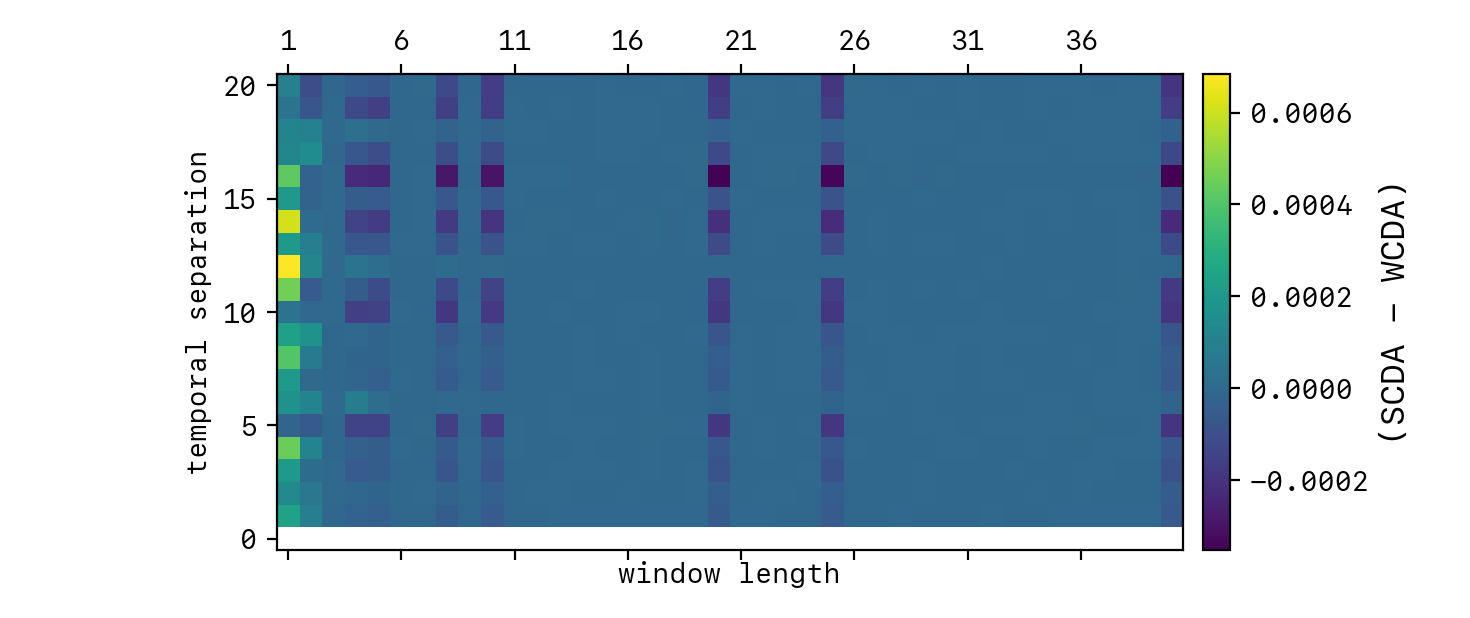

<IPython.core.display.Javascript object>


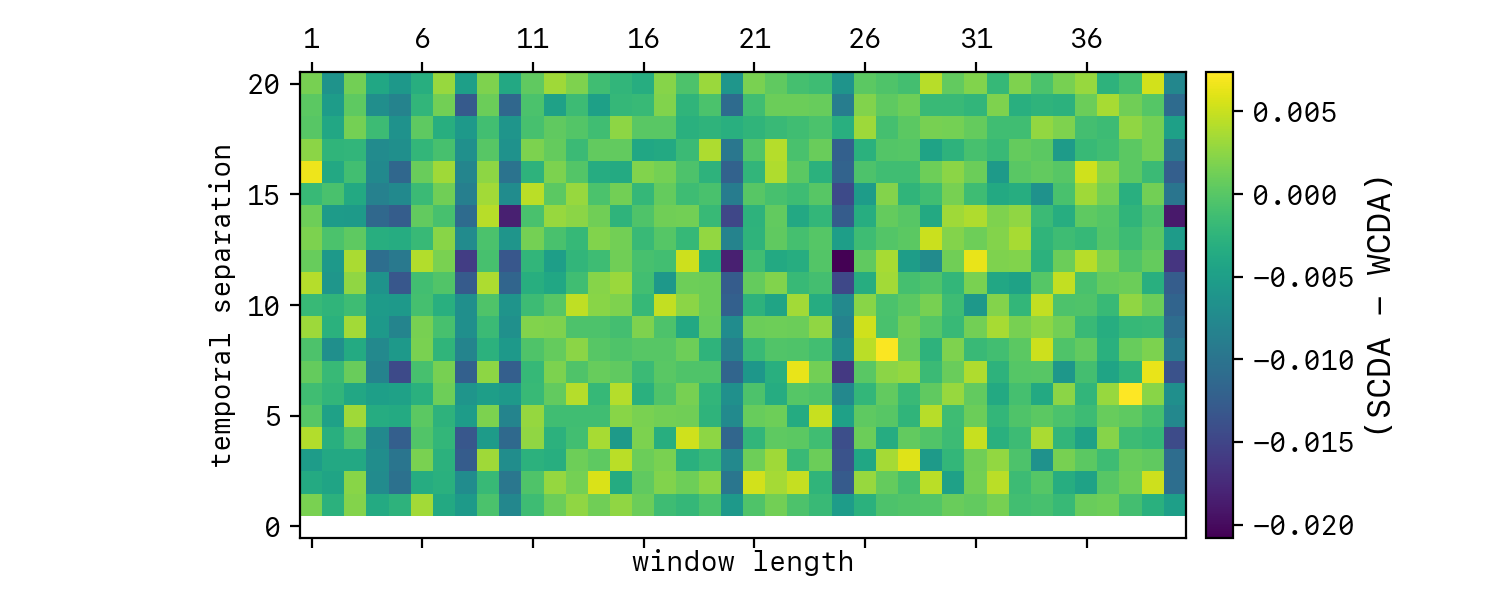

In [9]:
OutO = np.loadtxt(pwd + '/ToyModel_1/Data/Ocean_1.log', delimiter=',');
OutA = np.loadtxt(pwd + '/ToyModel_1/Data/Atmos_1.log', delimiter=',');

from mpl_toolkits.axes_grid1 import make_axes_locatable
%config InlineBackend.figure_format = 'svg'
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,4), dpi=100);
im = ax.matshow(np.array(OutO),origin='lower');
ax.grid(which='minor')
ax.set_aspect(1.0)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad = 0.1)
cb = plt.colorbar(im, cax=cax,label='(SCDA - WCDA)',orientation="vertical");
axc = cb.ax; text = axc.yaxis.label
text.set_font_properties(proplr)
ticks(axc,10); ticks(ax,10);
ax.set_xlabel('window length',fontproperties=font,fontsize=10); 
xlabels = ax.get_xticks().tolist()
xlabels_lag = [int(item + 1) for item in xlabels]
ax.set_xticklabels(xlabels_lag);
ax.set_ylabel('temporal separation',fontproperties=font,fontsize=10); 
ylabels = ax.get_yticks().tolist()
ylabels_lag = [int(item) for item in ylabels]
ax.set_yticklabels(ylabels_lag);
ax.set_title('Ocean',fontproperties=fontit,fontsize=12, y=1.20, loc='right');

fig, ax = plt.subplots(figsize=(8,4), dpi=100);
im = ax.matshow(np.array(OutA),origin='lower');
ax.grid(which='minor')
ax.set_aspect(1.0)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad = 0.1)
cb = plt.colorbar(im, cax=cax,label='(SCDA - WCDA)',orientation="vertical");
axc = cb.ax; text = axc.yaxis.label
text.set_font_properties(proplr)
ticks(axc,10); ticks(ax,10);
ax.set_xlabel('window length',fontproperties=font,fontsize=10); 
xlabels = ax.get_xticks().tolist()
xlabels_lag = [int(item + 1) for item in xlabels]
ax.set_xticklabels(xlabels_lag);
ax.set_ylabel('temporal separation',fontproperties=font,fontsize=10); 
ylabels = ax.get_yticks().tolist()
ylabels_lag = [int(item) for item in ylabels]
ax.set_yticklabels(ylabels_lag);
ax.set_title('Atmosphere',fontproperties=fontit,fontsize=12, y=1.20, loc='right');

# SCDA

Considering the general formulation of SCDA [[Car18]()] in the limit $\mathbf{H} = \mathbf{I}$,

$$\mathbf{K} = \mathbf{P}\,\big[\mathbf{P} + \mathbf{R}\big]^{-1},$$

where,

$$\mathbf{P} =
\begin{bmatrix}
    \langle\mathsf{T_O}\rangle & \langle\mathsf{T_O},\,\mathsf{T_A}\rangle \\
    \langle\mathsf{T_A},\,\mathsf{T_O}\rangle & \langle\mathsf{T_A}\rangle 
\end{bmatrix},\;\;\;\mathbf{R} =
\begin{bmatrix}
    \langle\sigma_{\mathsf{O},\mathit{o}}^2\rangle & 0.0 \\
    0.0 & \langle\sigma_{\mathsf{A},\mathit{o}}^2\rangle 
\end{bmatrix}.$$

We can calculate the diagonal and cross-component values of the Kalman Gain matrix $\mathbf{K}$ as

$$\mathbf{K} =
\frac{1}{\mathrm{D}}\begin{bmatrix}
    \langle{\mathsf{T_A}\rangle[\langle\mathsf{T_O}\rangle + \sigma_{\mathsf{O},\mathit{o}}^2] - \langle\mathsf{T_O},\mathsf{T_A}\rangle^2} & \sigma_{\mathsf{A},\mathit{o}}^2\langle\mathsf{T_O}\,\mathsf{T_A}\rangle \\
    \sigma_{\mathsf{O},\mathit{o}}^2\langle\mathsf{T_A},\mathsf{T_O}\rangle & \langle{\mathsf{T_O}\rangle[\langle\mathsf{T_A}\rangle + \sigma_{\mathsf{A},\mathit{o}}^2] - \langle\mathsf{T_O},\mathsf{T_A}\rangle^2} 
\end{bmatrix},$$

where,

$$\mathrm{D} = [\langle\mathsf{T_O}\rangle + \sigma_{\mathsf{O},\mathit{o}}^2]\,[\langle\mathsf{T_A}\rangle + \sigma_{\mathsf{A},\mathit{o}}^2] - \langle\mathsf{T_O},\mathsf{T_A}\rangle^2$$

In the absence of model error cross-correlations, i.e. $\langle\mathsf{T_O},\mathsf{T_A}\rangle \rightarrow 0$, the off-diagonal elements become 0 while the diagonal terms tend to WCDA system. In the presence of model error cross-correlation, the off-diagonal terms <font color='red'>DO NOT</font> resemble the results in [[Lu15]()]. This implementation conserves the total information.

## Compare SimCC with SCDA

Compare expressions for atmosphere $\rightarrow$ ocean cross update terms:

### SimCC
$$\mathsf{K} = \frac{\langle\mathsf{T}^f_\mathsf{O},{\mathsf{T}^f_\mathsf{A}}\rangle}{\langle{\mathsf{T}^f_\mathsf{A}}\rangle + \sigma_{\mathsf{A},\mathsf{o}}^2}$$

### SCDA

$$\mathsf{K} = \frac{\sigma_{\mathsf{O},\mathit{o}}^2\langle\mathsf{T}^f_\mathsf{O}\,\mathsf{T}^f_\mathsf{A}\rangle}{[\langle\mathsf{T}^f_\mathsf{O}\rangle + \sigma_{\mathsf{O},\mathit{o}}^2]\,[\langle\mathsf{T}^f_\mathsf{A}\rangle + \sigma_{\mathsf{A},\mathit{o}}^2] - \langle\mathsf{T}^f_\mathsf{O},\mathsf{T}^f_\mathsf{A}\rangle^2}$$

SimCC valid only when

$$\langle\mathsf{T}^f_\mathsf{O},{\mathsf{T}^f_\mathsf{A}}\rangle \leq \sigma_{\mathsf{A},\mathit{o}}\,\sigma_{\mathsf{O},\mathit{o}}.$$

# Leading average cross-correlation (LACC)

Considering LACC [[Lu15](https://www.dropbox.com/s/0bmtizuck5yafto/Lu15a.pdf?dl=0)] and the results in previous section, the Kalman gain is maximised when the average of $\mathsf{N}$ leading atmospheric forecasts are selected for the analysis step in SCDA. This dependence of Kalman gain on leading forecasts is written as

$$\mathsf{K} = \frac{\langle\mathsf{T_O}(t)\,\overline{\mathsf{T_A}(t_1,t_2)}\rangle}{\langle\overline{\mathsf{T_A}(t_1,t_2)}\rangle + \displaystyle\frac{\sigma_{\mathsf{A},\mathit{o}}^2}{\tau}} \propto \langle\mathsf{T_O}(t)\,\overline{\mathsf{T_A}(t_1,t_2)}\rangle$$

where, $t_1 < t_2 \leq t$ contains $\mathsf{N}$ leading atmospheric forecasts and $\tau = |t_1 - t_2|$. In principle, in regions where the oceanic and atmopheric forecasts are strongly correlated, deviations from the forecasts, as obtained through observations, provide the highest signal-to-noise ratio (SNR) for the analysis step of the DA. This is the core ideology behind the [LACC](https://www.dropbox.com/s/0bmtizuck5yafto/Lu15a.pdf?dl=0) method. For simplicity, we'll term the factor $\langle\mathsf{T_O}(t)\,\overline{\mathsf{T_A}(t_1,t_2)}\rangle$ as 'Kalman Gain', if/when required for simplicity.

Note: The <font color='blue'>KalGain()</font> function sets the DA step size equal to the peak cross-correlation lag time.